In [432]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import datetime

In [433]:
df = pd.read_csv(
    '/Users/maria/Documents/spiced/spiced_projects/spiced_repo/week7/data/ECA_blended_custom/TG_STAID002759.txt', 
    skiprows=19, 
    skipinitialspace=True,
)

In [434]:
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53352,111448,20220127,44,0
53353,111448,20220128,49,0
53354,111448,20220129,58,0
53355,111448,20220130,58,0


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53357 entries, 0 to 53356
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOUID   53357 non-null  int64
 1   DATE    53357 non-null  int64
 2   TG      53357 non-null  int64
 3   Q_TG    53357 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [436]:
df.describe()

,SOUID,DATE,TG,Q_TG
count,53357.000000,5.335700e+04,53357.000000,53357.000000
mean,119357.653541,1.948610e+07,57.050415,0.032910
std,8023.826001,4.217116e+05,614.099351,0.543108
min,111448.000000,1.876010e+07,-9999.000000,0.000000
25%,111448.000000,1.912071e+07,33.000000,0.000000
50%,111448.000000,1.949012e+07,94.000000,0.000000
75%,127488.000000,1.985072e+07,157.000000,0.000000
max,128124.000000,2.022013e+07,305.000000,9.000000


In [437]:
df.drop(['SOUID'], axis=1, inplace=True)

In [438]:
df['DATE'] = df['DATE'].astype(str)
df.set_index(pd.to_datetime(df['DATE']), inplace= True)
df.drop(['DATE'], axis=1, inplace=True)

In [439]:
df['T'] = df['TG']*0.1
df.drop(['TG'], axis=1, inplace=True)

In [440]:
df

,Q_TG,T
DATE,,
1876-01-01,0,2.2
1876-01-02,0,2.5
1876-01-03,0,0.3
1876-01-04,0,-5.8
1876-01-05,0,-9.8
...,...,...
2022-01-27,0,4.4
2022-01-28,0,4.9
2022-01-29,0,5.8


# Imputation

In [441]:
# Quality coloumn contains info for missing values
df['Q_TG'].value_counts()

0    53161
9      195
1        1
Name: Q_TG, dtype: int64

In [442]:
missing_values = df[df['Q_TG']==9]
missing_values.index 

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='DATE', length=195, freq=None)

The 195 missing values are the days between 25.04.1945 and 05.11.1945. 

To impute them, I take the mean temperatures from 2 years before and two years after:

In [443]:
before = df.loc['1943-04-25':'1945-04-24']
after = df.loc['1945-11-06':'1947-11-05']
before = before.groupby([before.index.month, before.index.day]).mean()
after = after.groupby([after.index.month, after.index.day]).mean()

In [444]:
for date in missing_values.index:
    df.loc[date,'T'] = round((before.loc[(date.month,date.day),'T']+ 
                              after.loc[(date.month,date.day),'T'])/2,1)

In [445]:
# Quality coloumn is not needed any more
df.drop(['Q_TG'], axis=1, inplace=True)

# Train - Test Split

In [446]:
df_train = pd.DataFrame.copy(df.loc[:'2015-12-31'])
df_test = pd.DataFrame.copy(df.loc['2016-01-01':])

# ARIMA

In [447]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


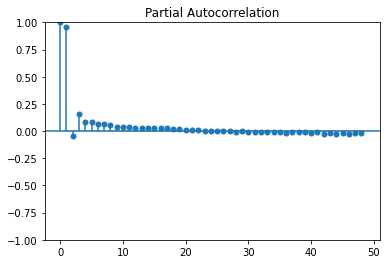

In [448]:
plot_pacf(df_train['T']);

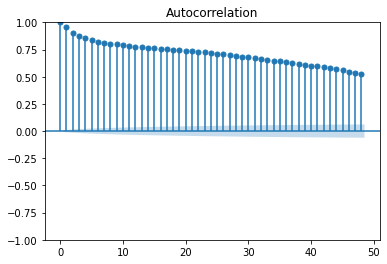

In [449]:
plot_acf(df_train['T']);

In [450]:
from statsmodels.tsa.arima.model import ARIMA

In [451]:
arima_model = ARIMA(df_train['T'], order=(3, 1, 1))

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [452]:
arima_model_fit = arima_model.fit()

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [453]:
print(arima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      T   No. Observations:                51134
Model:                 ARIMA(3, 1, 1)   Log Likelihood             -114919.991
Date:                Mon, 23 May 2022   AIC                         229849.981
Time:                        18:20:45   BIC                         229894.192
Sample:                    01-01-1876   HQIC                        229863.816
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8528      0.006    134.688      0.000       0.840       0.865
ar.L2         -0.2008      0.005    -37.600      0.000      -0.211      -0.190
ar.L3          0.0420      0.005      8.571      0.0

In [454]:
residuals = pd.DataFrame(arima_model_fit.resid)

<AxesSubplot:ylabel='Density'>

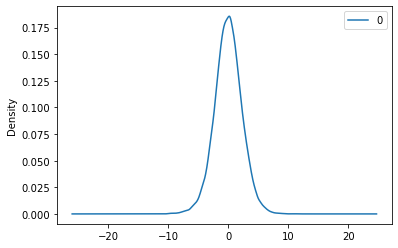

In [455]:
residuals.plot(kind='kde')

In [456]:
residuals.describe()

,0
count,51134.000000
mean,0.000289
std,2.289985
min,-13.310106
25%,-1.439616
50%,0.005473
75%,1.452039
max,12.026186


In [457]:
#df_train['arima_prediction'] = arima_model_fit.predict()

In [458]:
# mod = list(set([y for y in df_train.index.year if not y%10]))
# for decade in random.sample(mod[:-2],3):
#     plt.figure(figsize=(19,10))
#     start = f'{decade}-01-01'
#     end = f'{decade+9}-12-31'
#     sns.lineplot(data = df_train['T'].loc[start:end].resample('W').mean())
#     sns.lineplot(data = df_train['arima_prediction'].loc[start:end].resample('W').mean())
#     plt.ylabel('Temp',size=30)
#     plt.xlabel('Date',size=30)  
#     plt.xticks(size=17)
#     plt.yticks(size=17)
#     sns.despine()

In [459]:
output = arima_model_fit.forecast()
output

2016-01-01    1.804433
Freq: D, dtype: float64

In [460]:
df_test.loc['2016-01-01']

T    1.6
Name: 2016-01-01 00:00:00, dtype: float64

In [461]:
from sklearn.metrics import mean_squared_error

In [471]:
test = df_test['T'].iloc[:10]
type(test)

pandas.core.series.Series

In [472]:
history = df_train.copy()
type(history)

pandas.core.frame.DataFrame

In [470]:
predictions = []
for i,T in enumerate(test):
	print(history.iloc[-1])
	model = ARIMA(history, order=(3,2,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	history = pd.concat([history,pd.DataFrame({'T':output[0]}, index=output.index)])
	yhat = output[0]
	predictions.append(yhat)
	print('predicted=%f, expected=%f' % (yhat, T))



T    0.2
Name: 2015-12-31 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.142362, expected=1.600000
T    1.142362
Name: 2016-01-01 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.631020, expected=-3.600000
T    1.63102
Name: 2016-01-02 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.521287, expected=-9.800000
T    1.521287
Name: 2016-01-03 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.337009, expected=-9.100000
T    1.337009
Name: 2016-01-04 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.304135, expected=-8.400000
T    1.304135
Name: 2016-01-05 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.347546, expected=-7.800000
T    1.347546
Name: 2016-01-06 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.372685, expected=-5.500000
T    1.372685
Name: 2016-01-07 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.368614, expected=3.200000
T    1.368614
Name: 2016-01-08 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.359651, expected=0.900000
T    1.359651
Name: 2016-01-09 00:00:00, dtype: float64


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=1.357664, expected=0.600000


In [ ]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# TODO Make it stationary, add frequencies